Doubly Robust Learningによる因果推論

DR法に対し，反実仮想を想定することに変わりはないが，Z=1とみなしたときのYには個別誤差が乗っているので，それを極力緩和したい，という発想．

In [1]:
# 乱数シード
import random
import numpy as np

np.random.seed(1234)
random.seed(1234)


# 使用するパッケージ（ライブラリと関数）を定義
# 標準正規分布の生成用
from numpy.random import *
# グラフの描画用
import matplotlib.pyplot as plt
import japanize_matplotlib

# SciPy 平均0、分散1に正規化（標準化）関数
import scipy.stats
# シグモイド関数をimport
from scipy.special import expit
# その他
import pandas as pd

# 自作データの作成

Text(0, 0.5, '研修効果の大きさt(x)')

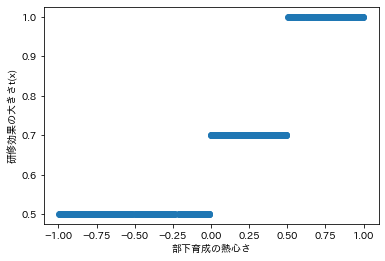

In [2]:
num_data = 500

# 部下育成への熱心さ
x = np.random.uniform(low=-1, high=1, size=num_data)

# 上司が「研修に参加」したかどうか
e_z = randn(num_data)
z_prob = expit(5.0*x+5*e_z) # 熱心である程参加しやすい
Z = np.array([])

for i in range(num_data):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)
    
# 介入効果の「非線形性」: 部下育成の熱心さxの値に応じて
# 研修効果は段階的（今回は特に離散的）に変化するとする
t = np.zeros(num_data)
for i in range(num_data):
    if x[i] < 0:
        t[i] = 0.5
    elif x[i] >= 0 and x[i] < 0.5:
        t[i] = 0.7
    elif x[i] >= 0.5:
        t[i] = 1.0

# 部下育成の熱心さに対する研修効果の可視化
## 熱心であれば効果が非線形に高くなるとする
plt.scatter(x, t )
plt.xlabel('部下育成の熱心さ')
plt.ylabel('研修効果の大きさt(x)')

In [3]:
# 満足度
e_y = randn(num_data)
Y = 2.0 + t*Z + 0.3*x + 0.1*e_y

## 満足度Yの可視化

In [4]:
df = pd.DataFrame({
    'x': x,
    'Z': Z,
    't': t,
    'Y': Y,
})

In [5]:
df.head()

,x,Z,t,Y
0,-0.616961,0.0,0.5,1.803183
1,0.244218,1.0,0.7,2.668873
2,-0.124545,0.0,0.5,2.193123
3,0.570717,1.0,1.0,3.245229
4,0.559952,1.0,1.0,3.139868


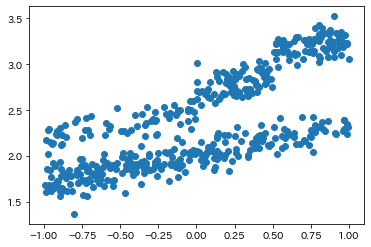

In [6]:
plt.scatter(x, Y)

# DR-Learner

## まずはT-Learner

In [7]:
# ランダムフォレストモデルを作成
from sklearn.ensemble import RandomForestRegressor

# 集団を2つに分ける
df_0 = df[df.Z == 0.0]  # 介入を受けていない集団
df_1 = df[df.Z == 1.0]  # 介入を受けた集団

# 介入を受けていないモデル
M_0 = RandomForestRegressor(max_depth=3)
M_0.fit(df_0[["x"]], df_0[["Y"]])

# 介入を受けたモデル
M_1 = RandomForestRegressor(max_depth=3)
M_1.fit(df_1[["x"]], df_1[["Y"]])

<ipython-input-7-bb3821e6ba86>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  M_0.fit(df_0[["x"]], df_0[["Y"]])
<ipython-input-7-bb3821e6ba86>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  M_1.fit(df_1[["x"]], df_1[["Y"]])


RandomForestRegressor(max_depth=3)

## 傾向スコアの算出

In [8]:
from sklearn.linear_model import LogisticRegression

# 説明変数
X = df[["x"]]

# 目的変数
Z = df["Z"]

# 回帰の実施
g_x = LogisticRegression().fit(X, Z)
g_x_val = g_x.predict_proba(X)

## DR法に基づく推定

ITE: Individual Treatment Effect

In [12]:
# 処置群
Y_1 = M_1.predict(df_1[['x']]) + \
    (df_1['Y'] - M_1.predict(df_1[['x']])) / g_x.predict_proba(df_1[['x']])[:, 1] # [:, 1]はZ=1の確率kk
df_1["ITE"] = Y_1 - M_0.predict(df_1[['x']])

# 非処置群
Y_0 = M_0.predict(df_0[['x']]) + \
    (df_0['Y'] - M_0.predict(df_0[['x']])) / g_x.predict_proba(df_0[['x']])[:, 0] # [:, 0]はZ=0の確率kk
df_0["ITE"] = M_1.predict(df_0[['x']]) - Y_0

# 結合
df_DR = pd.concat([df_0, df_1])
df_DR.head()

<ipython-input-12-4d252c195375>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["ITE"] = Y_1 - M_0.predict(df_1[['x']])
<ipython-input-12-4d252c195375>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0["ITE"] = M_1.predict(df_0[['x']]) - Y_0


,x,Z,t,Y,ITE
0,-0.616961,0.0,0.5,1.803183,0.514190
2,-0.124545,0.0,0.5,2.193123,0.081865
5,-0.454815,0.0,0.5,1.973293,0.333970
6,-0.447071,0.0,0.5,1.953387,0.364906
9,0.751865,0.0,1.0,2.289369,0.776072


## モデルM_DRの構築

<ipython-input-13-7f38a5da3505>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  M_DR.fit(df_DR[['x']], df_DR[['ITE']])


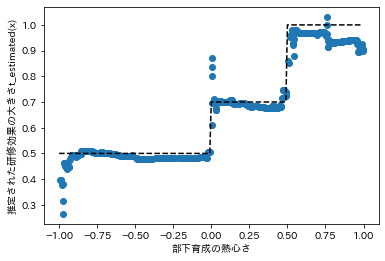

In [13]:
M_DR = RandomForestRegressor(max_depth=3)
M_DR.fit(df_DR[['x']], df_DR[['ITE']])

# 推定された介入効果を各人ごとに求める
t_estimated = M_DR.predict(df_DR[['x']])

plt.scatter(df_DR[['x']], t_estimated)
plt.xlabel('部下育成の熱心さ')
plt.ylabel('推定された研修効果の大きさt_estimated(x)')


# 正解のグラフを重畳
x_index = np.arange(-1, 1, 0.01)
t_ans = np.zeros(len(x_index))
for i in range(len(x_index)):
    if x_index[i] < 0:
        t_ans[i] = 0.5
    elif x_index[i] >= 0 and x_index[i] < 0.5:
        t_ans[i] = 0.7
    elif x_index[i] >= 0.5:
        t_ans[i] = 1.0
        
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')